In [11]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.captureWarnings(True)

import descarteslabs as dl
import descarteslabs.workflows as wf

import matplotlib.pyplot as plt

## Proxy Objects

The boring fundamentals you should know

In [12]:
one = wf.Int(1)  # this is a lazy proxy object.
two = one + 1

# 1 + 1 hasn't been computed yet:
# `two` holds a dependency graph representing the operation `1 + 1`
two

In [13]:
two.compute()  # send that graph to the backend, execute it, wait for the result

[######] | Steps: 0/0 | Stage: DONE | Status: SUCCESS                         

2

In [14]:
# use `block=False` to submit a computation asynchronously, returning a Job object
job = two.compute(block=False)

In [15]:
job.refresh()  # reload the job's status
job.done       # is it done?

False

In [16]:
job.result()  # wait for and load the result

[######] | Steps: 0/0 | Stage: DONE | Status: SUCCESS                         

2

## Image Basics

In [17]:
img = wf.Image.from_id("13ee3865fe538f2baf9c51f7316c57d25bece097:sinu-cat:sinu-cat")
# An Image is a proxy object holding multiple (ordered) bands of raster data,
# plus some metadata.

# Images don't have a set spatial extent, CRS, resolution, etc:
# that's determined at computation time by the GeoContext you pass in (keep reading!)

In [18]:
img.properties

<descarteslabs.workflows.types.containers.known_dict.KnownDict[{'crs': Str, 'date': Datetime, 'geotrans': Tuple[Float, Float, Float, Float, Float, Float], 'id': Str, 'product': Str}, Str, Any] at 0x1212907f0>

In [19]:
# Workflows knows in advance what some properties will be, and can return the right type of object.
# Here, 'date' is always a Datetime.
img.properties['date']

In [20]:
# Unknown properties are returned as a `wf.Any` object.
# `Any` supports any operation, but if the property doesn't exist,
# or you try to do something invalid with it, that'll cause an error at compute time.
img.properties['foobar']

In [21]:
img.bandinfo

<descarteslabs.workflows.types.containers.dict_.Dict[Str, KnownDict[{'data_range': Tuple[Float, Float], 'id': Str, 'name': Str}, Str, Any]] at 0x12242f898>

In [22]:
rgb = img.pick_bands('red green blue')
# Image with just the RGB bands (in that order)
# previously, `img` contained every band defined for that image.

In [23]:
# computing an Image (or other geospatial object) requires a GeoContext.

# Workflows has its own GeoContext proxy type, but you can also use
# GeoContext objects (including `DLTile`s) from `dl.scenes` interchangeably.

# get the default GeoContext for this image from Scenes
_, ctx = dl.scenes.Scene.from_id("13ee3865fe538f2baf9c51f7316c57d25bece097:sinu-cat:sinu-cat")

rgb_result = rgb.compute(ctx)

[######] | Steps: 17/17 | Stage: DONE | Status: SUCCESS                       

In [24]:
# .compute returns a simple container type to hold the NumPy array and metadata dictionaries
# from the result.

# this `workflows.containers.containers.Image` object is *different* from the
# `Image` objects we've been working with above; it's just a simple class
# for holding results
rgb_result

In [25]:
type(rgb_result.bands), rgb_result.bands.shape

(numpy.ma.core.MaskedArray, (3, 500, 500))

In [26]:
rgb_result.properties

{'acquired': '2018-11-02T03:18:46.349+00:00',
 'bucket': 'storage-13ee3865fe538f2baf9c51f7316c57d25bece097-products',
 'descartes_version': 'dl-platform-ingest',
 'directory': '13ee3865fe538f2baf9c51f7316c57d25bece097:sinu-cat/',
 'file_md5s': ('28d86678cda34bc1b235009b4f3f8e09',),
 'file_sizes': (1001598,),
 'files': ('28d86678cda34bc1b235009b4f3f8e09.tif',),
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-79.10810710223798, 62.952441458184595],
    [19.777026775559495, 62.952441458184595],
    [9.455287969178897, 17.986411845195597],
    [-37.82115187671559, 17.986411845195597],
    [-79.10810710223798, 62.952441458184595]]]},
 'geotrans': (-4000000.0, 10000.0, 0.0, 7000000.0, 0.0, -10000.0),
 'id': '13ee3865fe538f2baf9c51f7316c57d25bece097:sinu-cat:sinu-cat',
 'identifier': '13ee3865fe538f2baf9c51f7316c57d25bece097:sinu-cat/sinu-cat.tif',
 'key': 'sinu-cat',
 'owner_type': 'user',
 'owners': ('user:13ee3865fe538f2baf9c51f7316c57d25bece097',
  'org:descarteslabs'),
 'processed'

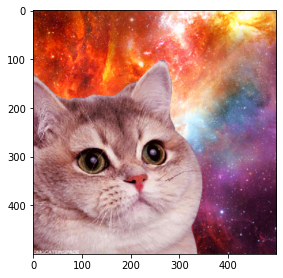

In [27]:
# our first real(?) data back from Workflows!
dl.scenes.display(rgb_result.bands, size=4)

In [28]:
# note that you can call `.compute` on pretty much any proxy object, not just the Image.
# If we pull out just the `geotrans` of the Image, our computation won't even touch any raster data.
# (see how there were 0 steps to do)

rgb.properties['geotrans'].compute(ctx)

[######] | Steps: 0/0 | Stage: DONE | Status: SUCCESS                         

(-4000000.0, 10000.0, 0.0, 7000000.0, 0.0, -10000.0)

In [29]:
# let's calculate some band math

red, blue = img.unpack_bands('red blue')
# same as:
# red = img.pick_bands('red')
# blue = img.pick_bands('blue')
# (but less typing)

In [30]:
# Like NumPy arrays, Image objects support vectorized operators like +, -, etc.
# The broadcasting rules are the similar:

FAIL = img.pick_bands('red green') * img.pick_bands('red green blue')
# the bands don't match between the two Images

OK = img.pick_bands('green') * img.pick_bands('red green blue')
# a 1-band Image is broadcast to all bands in the other Image.
# this would multiply `red`, `green`, and `blue` by the `green` band and return a 3-band Image

OK = img.pick_bands('green') * img.pick_bands('blue')
# if *both* Images have 1 band, it's ok if their names don't match

OK = img.pick_bands('red green blue') * img.pick_bands('blue red green')
# bands are matched up by name, not positionally.
# this would multiply red by red, blue by blue, and green by green
# (even though they're in different orders)

In [31]:
radness = (blue - red) / (blue + red)
# calculate Normalized Difference Radness Index

# IMPORTANT: values in Workflows images are always floats,
# and are rescaled to *physical rage* if it's defined

[######] | Steps: 5/5 | Stage: DONE | Status: SUCCESS                         

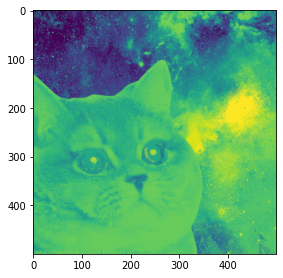

In [32]:
radness_ = radness.compute(ctx)
dl.scenes.display(radness_.bands, size=4, colormap="viridis")

## Visualization

In [33]:
# an interactive map widget that all layers get added to
wf.map


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart Jupyter and re-run this notebook.


^ in JupyterLab, right-click this and select "New view for output"

then drag it to the right side, or rearrange however you like

In [34]:
wf.map.center = [42, -20]
wf.map.zoom = 5

In [35]:
rgb.visualize("sinucat", scales=[[0, 1], [0, 1], [0, 1]])
# adds a layer named "sinucat" to `wf.map`.

# you won't see anything under this cell---just above, where we displayed `wf.map`.
# that's why the "New vew for output" is helpful; then you can look at `wf.map`
# and your code at the same time
    
# the image is computed on-the-fly by the backend as you zoom and pan around.
# note that we didn't give a GeoContext here:
# the GeoContext is defined by where you're looking on the map.

# if you see auth-related errors, log in at http://iam.descarteslabs.com and refresh the page

In [36]:
radness.visualize("NDRI", scales=[-1, 0.3], colormap="viridis")

# try changing the colormap here to "magma" and re-running the cell.
# notice that it doesn't add a new, duplicate layer; it just updates what's there.

# if you use the name ("NDRI" in this case) of an existing layer, it replaces it.
# so it's easy to tweak your `.visualize` cells in Jupyter and keep re-running them.

In [37]:
# mask out parts of the RGB Image where `radness` is low.
only_radness = rgb.mask(radness < -0.5)
only_radness.visualize("only radness", scales=[[0, 1], [0, 1], [0, 1]])

Now, try playing around with the map interface. You can rearrange layers, adjust scales and colormaps, and the magic-wand "enhance" button to pick scales automatically.

[######] | Steps: 13/13 | Stage: DONE | Status: SUCCESS                       

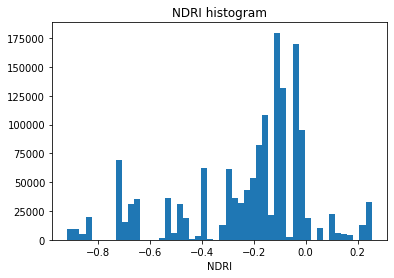

In [39]:
map_ctx = wf.map.geocontext()
# GeoContext that represents the current view area & zoom of the map

# try moving and zooming the map and rerunning this a few times;
# the computation runs over the area you're looking at on the map.

map_radness_ = radness.compute(map_ctx)

plt.hist(map_radness_.bands.compressed().flat, bins=50)  # .compressed() removes any masked-out values
plt.title("NDRI histogram")
plt.xlabel("NDRI")
plt.show()

## ImageCollection basics

In [40]:
landsat_8 = wf.ImageCollection.from_id("landsat:LC08:01:T1:TOAR")
# an ImageCollection is like a cross between a 4D NumPy array and a list of Images.

# this ImageCollection (theoretically) contains every Image in Landsat 8.
# But when a GeoContex is supplied at computation time (either by a map, or passing one into .compute),
# the metadata lookup and computation will just happen within that area of interest.

In [41]:
green, swir1 = landsat_8.unpack_bands('green swir1')
# same interface as Image
# but here, `green` and `swir1` are ImageCollections of the green/swir1 band from every image in Landsat 8

In [42]:
ndsi = (green - swir1) / (green + swir1)
# ImageCollections also support vectorized operators
# This calculates NDSI over every image in Landsat 8

In [43]:
winter = ndsi.filter(
    lambda img:
        (img.properties['date'].month >= 11)
        | (img.properties['date'].month <= 5)
)
# .filter takes a function, runs it on every Image in the ImageCollection,
# and only keeps Images where the function returns True

# you can write this function in normal Python syntax, with a couple caveats:
#
# - no conditionals or control flow (if statements, for loops)
#
# - python `and` and `or` statements don't work for comparing booleans;
#   instead, use the bitwise `&` and `|` operators (like above).
#   be sure to wrap your statements in parenthesis like above:
#   the bitwise operators have higher precedence than `and` and `or`!
#
#   `(x > 1) & (y == 2)` : correct
#   `x > 1 & y == 2`     : not what you expected; equivalent to `x > (1 & y) == 2`

In [45]:
winter_mean = winter.mean(axis="images")
# .mean makes a mean composite of all Images, returing one Image.
# other compositors include `min`, `max`, `sum`, `std`, `median`, and `count`

# axes are similar to NumPy arrays: "images", "bands", "pixels", and/or None

In [46]:
# let's go to the himalaya
wf.map.clear_layers()
wf.map.center = [29, 83]
wf.map.zoom = 9

In [47]:
winter_mean.visualize("Winter mean snowiness", scales=[-0.4, 1], colormap="magma")
# winter mean NDSI composite over all of landsat 8 T1
# (this may take a while to load)

# remember, the output shows up on the cell where you ran `wf.map`, not under this one!

In [48]:
s1 = wf.ImageCollection.from_id("sentinel-1:GRD", start_datetime="2018-01-01", end_datetime="2018-08-01")
# you can give `start_datetime` and `end_datetime` for coarse date bounding,
# which is efficient than `filter`.
# of course, you can combine `start_datetime` and `filter` if you want

In [49]:
s1_img = s1.mean(axis="images")
# right now, we can only display Images on a map, not ImageCollections.
# so we make a mean composite of Sentinel-1 just for fun

In [50]:
vv, vh = s1_img.unpack_bands("vv vh")
vv_vh_product = (vv * vh)

In [51]:
low_snow = vv_vh_product.mask(winter_mean > 0.2)
# you can mask one Image or ImageCollection with another Image or ImageCollection that contains boolean values.
# like with NumPy, `True` means masked/invalid.

# also notice that we're interoperating between two different sensor products here:
# masking a sentinel-1 SAR composite with snow cover computed from landsat-8! neat!

In [52]:
low_snow.visualize('VV * VH', colormap="viridis", scales=[0.0, 0.03], checkerboard=False)

In [53]:
# try adjusing the masking threshold a few cells above and re-running the map.

# data should load quite a bit faster the second time around,
# because all the intermediate results are cached automatically.
# (namely, computing NDSI and making composites of Landsat 8 and Sentinel-1) 

## It's not just about the pixels

In [54]:
nir, red = landsat_8.unpack_bands('nir red')

In [55]:
ndvi = (nir - red) / (nir + red)

In [56]:
ndsi = ndsi.rename_bands('ndsi')
ndvi = ndvi.rename_bands('ndvi')
# the band name for NDVI was originally `nir_sub_red_div_nir_add_red`---continuing
# to call it `red` or `nir` would be inaccurate, so Workflows automatically
# changes the name---but we rename it to something more meaningful.

# `rename_bands` can take new names positionally (what we did here), or by keyword arguments
# (we could have done `renane_bands(nir_sub_red_div_nir_add_red="ndvi")`, but that's awkward to write)

In [57]:
ndvi_ndsi_col = ndvi.concat_bands(ndsi)
# `concat_bands` appends the bands from another Image or ImageCollection.

# note that this returns a *new* ImageCollection; it doesn't modify the original.
# in general, all values in Workflows are immutable, and operations return copies.
# (this isn't as inefficient as it sounds, because the underlying raster data isn't always copied.)

In [58]:
# define a function we'll map over every Image in the ImageCollection

def index_stats(img):
    date = img.properties['date']
    stats = img.mean(axis="pixels")
    # stats is a Dict[Str, Float], where keys are band names and values are the statistic (mean pixel value for that band).
    # that's why we renamed the bands, so the keys are nicer :)
    
    return (date, stats['ndvi'], stats['ndsi'])

In [59]:
l8_stats = ndvi_ndsi_col.map(index_stats)
# ImageCollection.map applies the function to every Image.

# if the mapper function returned an Image, we'd still get an ImageCollection back.
# however, our `index_stats` function just returns a tuple of a date and some numbers,
# so we get back a`workflows.List` proxy object.

In [60]:
type(l8_stats)

descarteslabs.workflows.types.containers.list_.List[Tuple[Datetime, Float, Float]]

In [61]:
# Notice that this is a `List[Tuple[Datetime, Float, Float]]`.
# That's not something you'd normally see in Python.

# The Workflows client is more strongly-typed than normal Python, and maintains its own type system.
# For example, values in `List`s all have to be the same type (in this case `Tuple[Datetime, Float, Float]`),
# and all the keys in a `Dict` are one type, and values are another type (as we saw above, with `Dict[Str, Float]`).

# This strictness helps prevent silly errors, and also lets it infer what type your results will be before you even execute them.

In [62]:
himalaya_tile = dl.scenes.DLTile.from_latlon(35, 76, 60, 512, 0)

In [63]:
l8_stats_ = l8_stats.compute(himalaya_tile)

[######] | Steps: 4966/4966 | Stage: DONE | Status: SUCCESS                   

In [64]:
l8_stats_[:5]
# look, we actually did get back a list of tuples of a date and two floats

[('2016-01-12T05:29:41.742998+00:00',
  0.018266330507218417,
  0.5031715320676207),
 ('2016-01-28T05:29:41.336400+00:00', 0.0140398823888516, 0.5351976492943566),
 ('2016-02-13T05:29:34.609452+00:00',
  0.025325696248472977,
  0.43473396881425297),
 ('2016-02-29T05:29:30.846120+00:00',
  0.015405631261259213,
  0.4693200603094098),
 ('2016-03-16T05:29:26.559706+00:00', 0.03459658795977355, 0.3951994492390837)]

In [65]:
import pandas as pd

In [66]:
# stick it into pandas for further analysis.
# notice we didn't have to bring any raster data back to our client.

df = pd.DataFrame.from_records(l8_stats_, index='date', columns=['date', 'ndvi', 'ndsi'])
df.index = pd.to_datetime(df.index)
df

,ndvi,ndsi
date,,
2016-01-12 05:29:41.742998+00:00,0.018266,0.503172
2016-01-28 05:29:41.336400+00:00,0.014040,0.535198
2016-02-13 05:29:34.609452+00:00,0.025326,0.434734
2016-02-29 05:29:30.846120+00:00,0.015406,0.469320
2016-03-16 05:29:26.559706+00:00,0.034597,0.395199
...,...,...
2019-05-03 05:35:14.188470+00:00,0.022808,0.397770
2019-05-19 05:35:24.708683+00:00,0.057409,0.162153
2019-06-20 05:35:39.182627+00:00,0.061109,0.242021


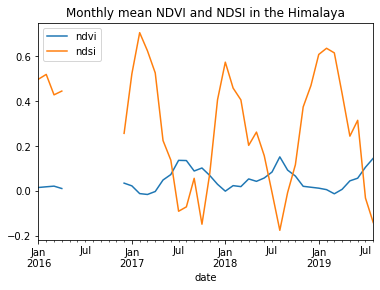

In [67]:
(
    df
    .resample("1m")
    .mean()
    .plot(title="Monthly mean NDVI and NDSI in the Himalaya")
)